In [1]:
# avoid non-compliant Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.transforms as transforms
from munch import Munch
from skimage.draw import circle
from skimage.measure import find_contours
from tqdm import tqdm_notebook as tqdm
from PIL import Image

import models
import utils

In [3]:
max_circle_size = 48
num_circles = 16
cache_dir = 'cache/occlusion_study/'

In [4]:
config_path = 'pretrained/floating_kinect1_mask/config.yml'
#config_path = 'pretrained/floating_kinect1_mask_with_occlusion/config.yml'

In [5]:
with open(config_path, 'r') as f:
    cfg = Munch.fromYAML(f)

In [6]:
model = models.Model(cfg.arch)
model = torch.nn.DataParallel(model).cuda()
cudnn.benchmark = True
checkpoint = torch.load(cfg.training.resume)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print("=> loaded checkpoint '{}' (epoch {})".format(cfg.training.resume, checkpoint['epoch']))

=> loaded checkpoint 'pretrained/floating_kinect1_mask/checkpoint_00002100.pth.tar' (epoch 2100)


In [7]:
class OccludedRenderedPoseMaskDataset(torch.utils.data.Dataset):
    def __init__(self, data_root, objects, subset_num, transform, max_circle_size, num_circles):
        self.transform = transform
        self.num_circles = num_circles

        # images
        image_dirs = []
        self.object_indices = []

        for o in objects:
            image_dirs.append(os.path.join(data_root, o, 'subset_{:08}'.format(subset_num)))
        for image_dir in image_dirs:
            assert os.path.exists(image_dir)
        self.image_paths = []
        for i, image_dir in enumerate(image_dirs):
            image_names = sorted(os.listdir(image_dir))
            self.image_paths.extend([os.path.join(image_dir, name) for name in image_names])
            self.object_indices.extend(i * np.ones(len(image_names)))
        self.object_indices = np.array(self.object_indices, dtype=np.int64)
        assert len(self.object_indices) == len(self.image_paths)

        # poses
        poses_paths = []
        for o in objects:
            poses_paths.append(os.path.join(data_root, o, 'poses', 'subset_{:08}.txt'.format(subset_num)))
        for poses_path in poses_paths:
            assert os.path.exists(poses_path)
        self.poses = []
        for poses_path in poses_paths:
            self.poses.extend(np.loadtxt(poses_path).astype(np.float32))
        assert len(self.poses) == len(self.image_paths)

        # precompute circular occlusions
        print('precomputing circular occlusions')
        random_state = np.random.RandomState(0)
        self.circle_sizes = max_circle_size * random_state.rand(self.num_circles * len(self.image_paths))
        self.circle_centers = []
        for image_path in tqdm(self.image_paths):
            contours = find_contours(np.asarray(Image.open(image_path)), 0)
            if len(contours) > 0:
                contour = sorted(contours, key=lambda x: -x.shape[0])[0]
            if len(contours) > 0 and len(contour) >= self.num_circles:
                contour_indices = random_state.choice(len(contour), self.num_circles, replace=False)
                self.circle_centers.extend(contour[contour_indices])
            else:
                # object is probably out of image or too small to occlude
                self.circle_centers.extend(self.num_circles * [None])

    def __getitem__(self, index):
        image_index = index // self.num_circles
        object_index = self.object_indices[image_index]

        image = Image.open(self.image_paths[image_index])
        occlusion_amount = 0

        # apply precomputed circular occlusion if possible
        if self.circle_centers[index] is not None:
            np_image = np.asarray(image)
            occluded_image = np_image.copy()
            r, c = self.circle_centers[index]
            circle_size = self.circle_sizes[index]
            rr, cc = circle(r, c, circle_size, shape=np_image.shape)
            occluded_image[rr, cc] = 0
            occlusion_amount = 1 - float(occluded_image.sum()) / np_image.sum()
            image = Image.fromarray(occluded_image)

        image = self.transform(image)

        # enforce quaternion [w, x, y, z] to have positive w
        target_pose = self.poses[image_index]
        if target_pose[3] < 0:
            target_pose[3:] = -target_pose[3:]

        return image, target_pose, object_index, occlusion_amount

    def __len__(self):
        return self.num_circles * len(self.image_paths)

In [8]:
transform = transforms.ToTensor()
val_dataset = OccludedRenderedPoseMaskDataset(
    cfg.data.root, cfg.data.objects, cfg.data.val_subset_num, transform, max_circle_size, num_circles)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)

precomputing circular occlusions


In [9]:
# visualize
#for image, _, _, occlusion_amount in val_loader:
#    plt.imshow(image[0].numpy()[0], cmap='gray')
#    plt.show()
#    print(occlusion_amount[0].item())

In [10]:
def forward_batch(model, input, target, object_index):
    target = target.cuda(non_blocking=True)
    object_index = object_index.cuda(non_blocking=True)

    position, orientation = model(input, object_index)
    position_error = (target[:, :3] - position).pow(2).sum(dim=1).sqrt()
    orientation_error = 180.0 / np.pi * utils.batch_rotation_angle(target[:, 3:], orientation)

    return position_error.cpu().numpy(), orientation_error.cpu().numpy()

In [11]:
occlusion_amounts = []
position_errors = []
orientation_errors = []
with torch.no_grad():
    for input, target, object_index, occlusion_amount in tqdm(val_loader):
        position_error, orientation_error = forward_batch(model, input, target, object_index)
        occlusion_amounts.extend(occlusion_amount)
        position_errors.extend(position_error)
        orientation_errors.extend(orientation_error)
position_errors = 100.0 * np.array(position_errors)
orientation_errors = np.array(orientation_errors)

In [12]:
num_bins = 100
bin_edges = np.linspace(0, 1, num_bins + 1)
left_edges = bin_edges[:num_bins]

In [13]:
p_mean = []
o_mean = []
for i in tqdm(range(num_bins)):
    mask = (bin_edges[i] <= occlusion_amounts) & (occlusion_amounts < bin_edges[i + 1])
    p_mean.append(position_errors[mask].mean())
    o_mean.append(orientation_errors[mask].mean())

In [14]:
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
cache_path = os.path.join(cache_dir, '{}.npy'.format(cfg.training.experiment_name))
np.save(cache_path, (p_mean, o_mean))

In [15]:
cache_path_wo_occlusion = os.path.join(cache_dir, '{}.npy'.format('floating_kinect1_mask'))
cache_path_with_occlusion = os.path.join(cache_dir, '{}.npy'.format('floating_kinect1_mask_with_occlusion'))
p_mean_wo_occlusion, o_mean_wo_occlusion = np.load(cache_path_wo_occlusion)
p_mean_with_occlusion, o_mean_with_occlusion = np.load(cache_path_with_occlusion)

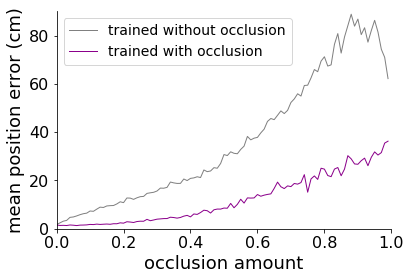

In [16]:
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.plot(left_edges, p_mean_wo_occlusion, color='gray', lw=1, label='trained without occlusion')
plt.plot(left_edges, p_mean_with_occlusion, color='darkmagenta', lw=1, label='trained with occlusion')
plt.xlim(0, 1)
plt.ylim(0, 90)
plt.xlabel('occlusion amount', fontsize=18)
plt.ylabel('mean position error (cm)', fontsize=18)
plt.legend(prop={'size': 14})
plt.savefig('figures/occlusion_position.pdf', bbox_inches='tight')

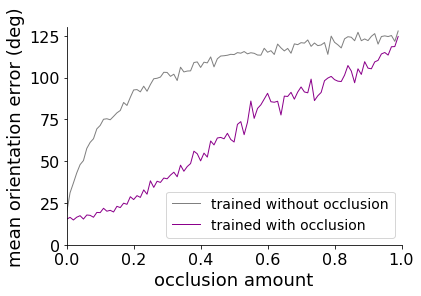

In [17]:
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.plot(left_edges, o_mean_wo_occlusion, color='gray', lw=1, label='trained without occlusion')
plt.plot(left_edges, o_mean_with_occlusion, color='darkmagenta', lw=1, label='trained with occlusion')
plt.xlim(0, 1)
plt.ylim(0, 130)
plt.xlabel('occlusion amount', fontsize=18)
plt.ylabel('mean orientation error (deg)', fontsize=18)
plt.legend(prop={'size': 14})
plt.savefig('figures/occlusion_orientation.pdf', bbox_inches='tight')